In [1]:
import numpy as np 
import torch
import math
import d2lzh as d2l
import matplotlib.pyplot as plt 

epoch 10,x: 0.06046617599999997


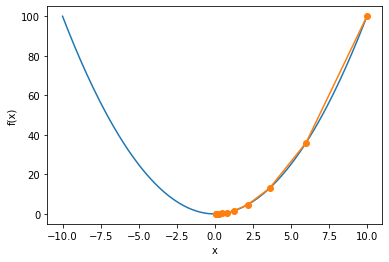

In [2]:
def gd(eta):
    x = 10
    results = [x]
    for i in range(10):
        x -= eta * 2 * x 
        results.append(x)
    print("epoch 10,x:",x)
    return results

res = gd(0.2)

def show_trace(res):
    n = max(abs(min(res)),abs(max(res)),10)
    f_line = np.arange(-n,n,0.1)
    plt.plot(f_line,[x * x for x in f_line])
    plt.plot(res,[x * x for x in res],"-o")
    plt.xlabel("x")
    plt.ylabel("f(x)")

show_trace(res)

epoch 10,x: 3.4867844009999995


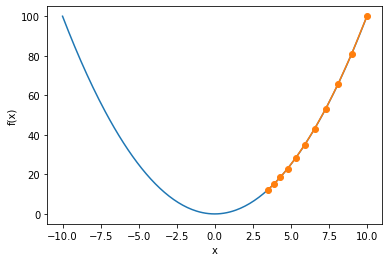

In [3]:
# 学习速率 0.05
show_trace(gd(0.05))

epoch 10,x: 61.917364224000096


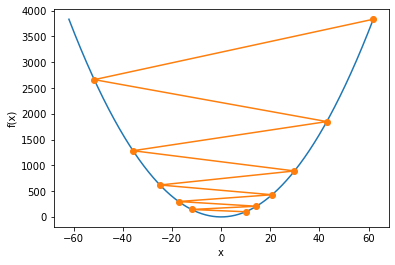

In [4]:
# 过大的学习速率1.1
show_trace(gd(1.1))

## 多维度梯度下降

epoch 20,x1 -0.057646,x2 -0.000073


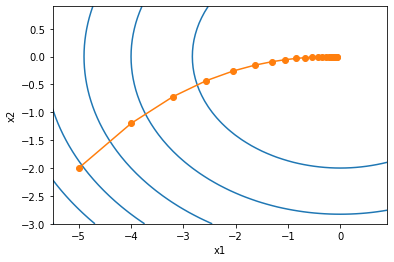

In [5]:
def train_2d(trainer):
    x1,x2,s1,s2 = -5,-2,0,0
    results = [(x1,x2)]
    for i in range(20):
        x1,x2,s1,s2 = trainer(x1,x2,s1,s2)
        results.append((x1,x2))

    print("epoch %d,x1 %f,x2 %f" %(i +1 ,x1,x2))
    return results

def show_trace_2d(f,results):
    plt.plot(*zip(*results),"-o",color="#ff7f0e")
    x1,x2 = np.meshgrid(np.arange(-5.5,1.0,0.1),np.arange(-3.0,1.0,0.1))
    plt.contour(x1,x2,f(x1,x2),colors="#1f77b4")
    plt.xlabel("x1")
    plt.ylabel("x2")

eta=0.1

def f_2d(x1,x2):
    return x1 ** 2 + 2 * x2 ** 2

def gd_2d(x1,x2,s1,s2):
    return (x1-eta * 2 * x1,x2 -eta * 4 * x2,0,0)

show_trace_2d(f_2d,train_2d(gd_2d))

epoch 20,x1 -0.160970,x2 -0.221283


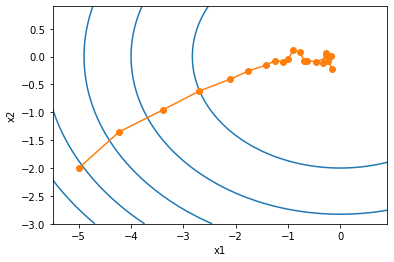

In [6]:
def sgd_2d(x1,x2,s1,s2):
    return (x1 - eta *(2 * x1 + np.random.normal(0.1)),
    x2 - eta * (4 * x2 + np.random.normal(0.1)),0,0)

show_trace_2d(f_2d,train_2d(sgd_2d))

## 7.3　小批量随机梯度下降

In [7]:
import numpy as np 
import matplotlib.pyplot as plt 
import time
import torch
import torch.nn as nn 
import d2lzh as d2l 

def get_data_ch7():
    data = np.genfromtxt("../data/airfoil_self_noise.data",delimiter="\t")
    data = (data - data.mean(axis=0)) / data.std(axis=0)
    return torch.tensor(data[:1500,:-1],dtype=torch.float32),torch.tensor(data[:1500,-1],dtype=torch.float32)

feature,labels = get_data_ch7()
feature.shape

torch.Size([1500, 5])

loss: 0.243531, 0.039447 sec per epoch 


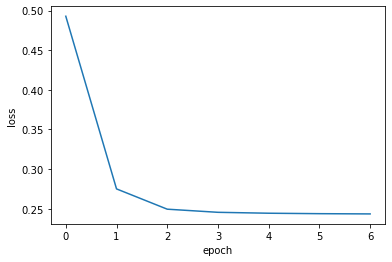

In [9]:
def sgd(params,states,hyperparams):
    for p in params:
        p.data -= hyperparams["lr"] *p.grad.data

def train_ch7(optimizer_fn,states,hyperparams,features,labels,batch_size=10,num_epochs=2):
    net,loss = d2l.linreg,d2l.squared_loss

    w = torch.nn.Parameter(torch.tensor(np.random.normal(0,0.01,size=(features.shape[1],1)),dtype=torch.float32),requires_grad=True)
    b = torch.nn.Parameter(torch.zeros(1,dtype=torch.float32),requires_grad=True)

    def eval_loss():
        return loss(net(features,w,b),labels).mean().item()

    ls = [eval_loss()]
    data_iter = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(features,labels),batch_size,shuffle=True)

    for _ in range(num_epochs):
        start = time.time()
        for batch_i,(x,y) in enumerate(data_iter):
            l = loss(net(x,w,b),y).mean()

            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()

            l.backward()
            optimizer_fn([w,b],states,hyperparams)
            if(batch_i + 1) * batch_size % 100 == 0:
                ls.append(eval_loss())

    print("loss: %f, %f sec per epoch "%(ls[-1],time.time()-start))
    plt.plot(np.linspace(0,num_epochs,len(ls)),ls)
    plt.xlabel("epoch")
    plt.ylabel("loss")

def train_sgd(lr,batch_size,num_epochs=2):
    train_ch7(sgd,None,{"lr":lr},feature,labels,batch_size,num_epochs)

train_sgd(1,1500,6)


loss: 0.246039, 0.290179 sec per epoch 


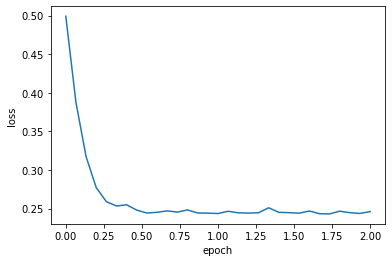

In [10]:
train_sgd(0.005,1)

loss: 0.244371, 0.042735 sec per epoch 


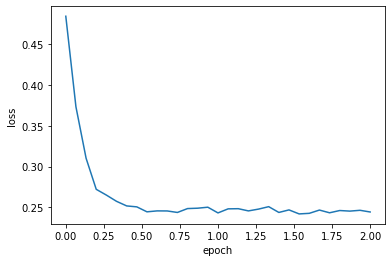

In [11]:
train_sgd(0.05,10)

batch较大，则一个训练周期内，迭代次数较少，每个训练周期的时间较短，就需要增大epoch；batch较小，一个训练周期内，迭代次数较多，每个训练周期的时间较长，可以减小epoch.

In [12]:
def train_pytorch_ch7(optimizer_fn,optimizer_hyperparams,features,labels,batch_size=10,num_epochs=2):

    net = nn.Sequential(
        nn.Linear(features.shape[-1],1)
    )
    loss = nn.MSELoss()

    optimizer = optimizer_fn(net.parameters(),**optimizer_hyperparams)

    def eval_loss():
        return loss(net(features).view(-1),labels).item() / 2

    ls = [eval_loss()]
    data_iter = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(features,labels),batch_size,shuffle=True)

    for _ in range(num_epochs):
        start = time.time()

        for batch_i,(x,y) in enumerate(data_iter):
            l = loss(net(x).view(-1),y) / 2

            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            if(batch_i + 1) * batch_size % 100 == 0:
                ls.append(eval_loss())

    print("loss: %f, %f sec per epoch "%(ls[-1],time.time()-start))
    plt.plot(np.linspace(0,num_epochs,len(ls)),ls)
    plt.xlabel("epoch")
    plt.ylabel("loss") 

loss: 0.244184, 0.032329 sec per epoch 


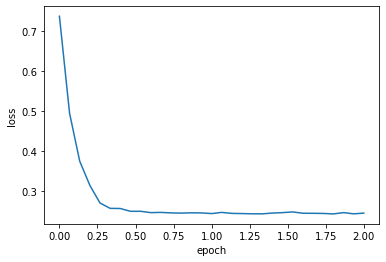

In [13]:
train_pytorch_ch7(torch.optim.SGD,{"lr":0.05},feature,labels,10)